In [1]:
import importlib
import seaborn as sns
import pandas as pd

import mysklearn.myutils
importlib.reload(mysklearn.myutils)
import mysklearn.myutils as myutils

# uncomment once you paste your mypytable.py into mysklearn package
import mysklearn.mypytable
importlib.reload(mysklearn.mypytable)
from mysklearn.mypytable import MyPyTable

import mysklearn.myclassifiers
importlib.reload(mysklearn.myclassifiers)

import matplotlib.pyplot as plt
import numpy as np

##### Step0: prepare data

In [2]:
df = pd.read_csv("archive/matches/matches/euro/2024.csv")
df.head()

,id_match,home_team,away_team,home_team_code,away_team_code,home_score,away_score,home_penalty,away_penalty,home_score_total,...,stadium_name,stadium_name_media,stadium_name_official,stadium_name_event,stadium_name_sponsor,home_lineups,away_lineups,home_coaches,away_coaches,events
0,2036211,Spain,England,ESP,ENG,2.0,1.0,NaN,NaN,2.0,...,Olympiastadion,Olympiastadion,Olympiastadion,Olympiastadion,Olympiastadion,"[{'country_code': 'ESP', 'name': 'David Raya',...","[{'country_code': 'ENG', 'name': 'Aaron Ramsda...","[{'country_code': 'ESP', 'country': 'Spain', '...","[{'country_code': 'ENG', 'country': 'England',...",[{'id': 'c9451938-1653-4ed3-82af-3c3b641c9933'...
1,2036210,Netherlands,England,NED,ENG,1.0,2.0,NaN,NaN,1.0,...,BVB Stadion Dortmund,BVB Stadion Dortmund,BVB Stadion Dortmund,BVB Stadion Dortmund,Signal Iduna Park,"[{'country_code': 'NED', 'name': 'Justin Bijlo...","[{'country_code': 'ENG', 'name': 'Aaron Ramsda...","[{'country_code': 'NED', 'country': 'Netherlan...","[{'country_code': 'ENG', 'country': 'England',...",[{'id': 'f5eaa274-731c-450c-b463-fa39b3159859'...
2,2036209,Spain,France,ESP,FRA,2.0,1.0,NaN,NaN,2.0,...,Munich Football Arena,Football Arena Munich,Fußball Arena München,Munich Football Arena,Allianz Arena,"[{'country_code': 'ESP', 'name': 'David Raya',...","[{'country_code': 'FRA', 'name': 'Brice Samba'...","[{'country_code': 'ESP', 'country': 'Spain', '...","[{'country_code': 'FRA', 'country': 'France', ...",[{'id': '1c23408d-cff7-4b73-984e-b0fe138a934e'...
3,2036207,Netherlands,Türkiye,NED,TUR,2.0,1.0,NaN,NaN,2.0,...,Olympiastadion,Olympiastadion,Olympiastadion,Olympiastadion,Olympiastadion,"[{'country_code': 'NED', 'name': 'Justin Bijlo...","[{'country_code': 'TUR', 'name': 'Altay Bayınd...","[{'country_code': 'NED', 'country': 'Netherlan...","[{'country_code': 'ITA', 'country': 'Italy', '...",[{'id': 'c127c084-8277-4dfa-8c97-259c9333c770'...
4,2036208,England,Switzerland,ENG,SUI,1.0,1.0,5.0,3.0,1.0,...,Düsseldorf Arena,Düsseldorf Arena,Düsseldorf Arena,Düsseldorf Arena,ESPRIT arena,"[{'country_code': 'ENG', 'name': 'Aaron Ramsda...","[{'country_code': 'SUI', 'name': 'Yvon Mvogo',...","[{'country_code': 'ENG', 'country': 'England',...","[{'country_code': 'SUI', 'country': 'Switzerla...",[{'id': '49a9453c-0547-472d-a5d1-2ee97d5ce688'...


##### Step1: attribute property

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


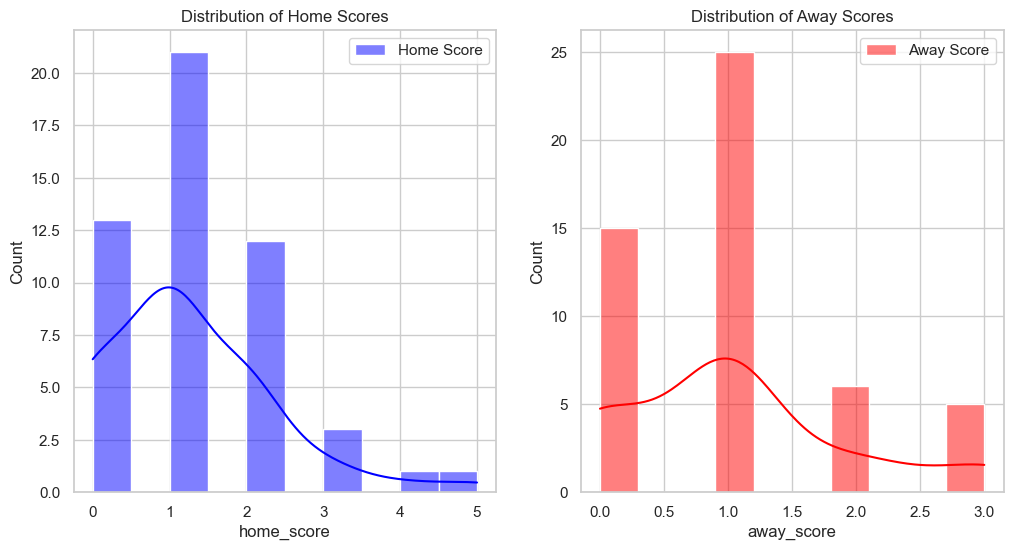

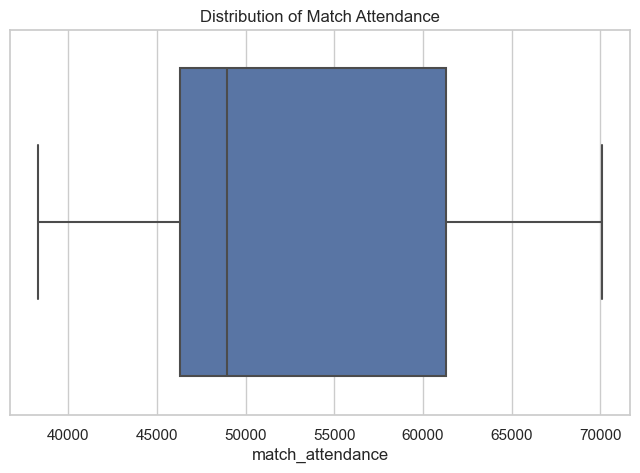

/opt/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


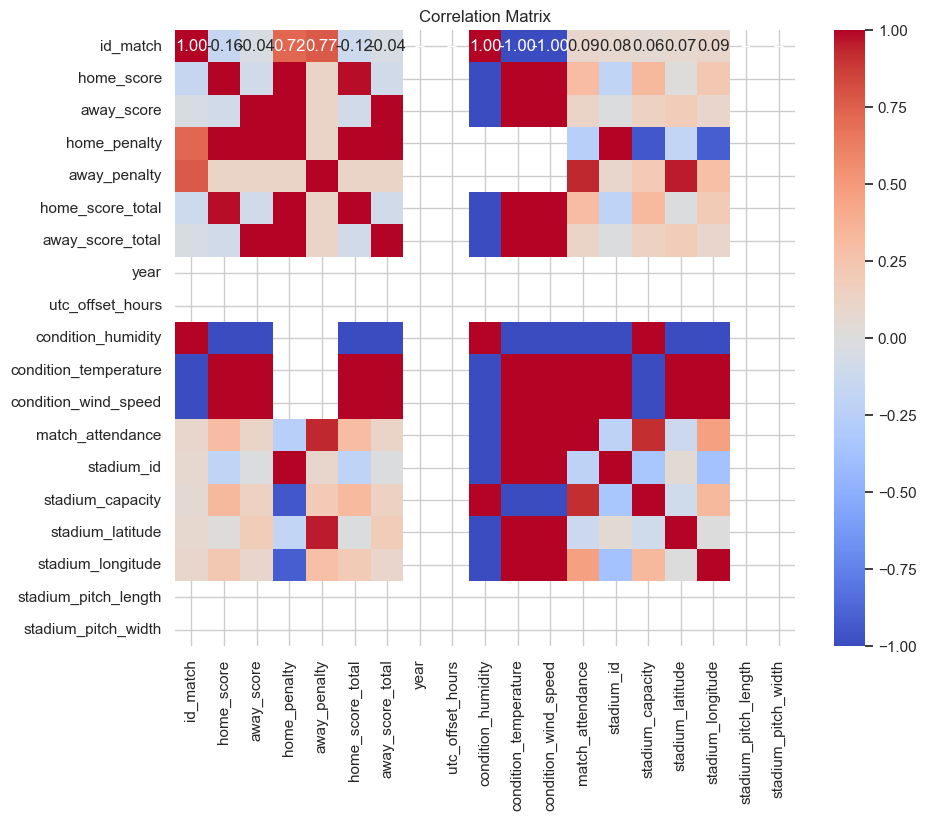

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Setting the aesthetic style of the plots
sns.set(style="whitegrid")

# Histograms for scores
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(df['home_score'], bins=10, kde=True, color='blue', label='Home Score')
plt.title('Distribution of Home Scores')
plt.legend()

plt.subplot(1, 2, 2)
sns.histplot(df['away_score'], bins=10, kde=True, color='red', label='Away Score')
plt.title('Distribution of Away Scores')
plt.legend()

plt.show()

# Boxplot for match attendance
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='match_attendance')
plt.title('Distribution of Match Attendance')
plt.show()

# Correlation matrix
corr = df.select_dtypes(include=[np.number]).corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()


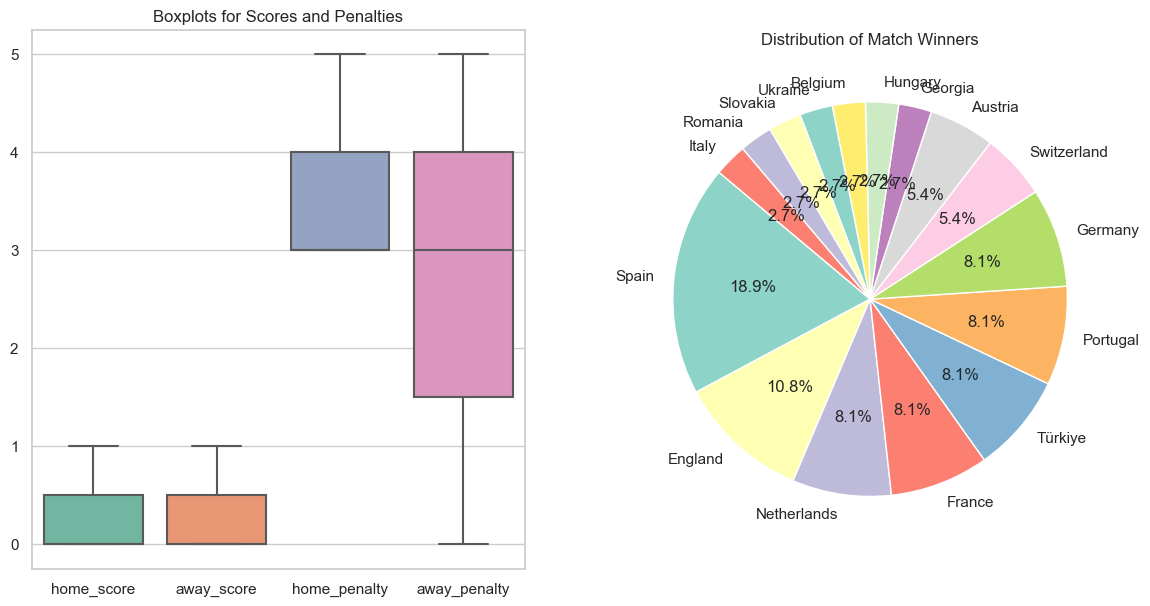

In [4]:
plt.figure(figsize=(14, 7))

# Boxplots for home and away scores and penalties
plt.subplot(1, 2, 1)
sns.boxplot(data=df[['home_score', 'away_score', 'home_penalty', 'away_penalty']].dropna(), palette="Set2")
plt.title('Boxplots for Scores and Penalties')

# Pie chart for winners
plt.subplot(1, 2, 2)
winner_counts = df['winner'].value_counts()
plt.pie(winner_counts, labels=winner_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette("Set3"))
plt.title('Distribution of Match Winners')

plt.show()


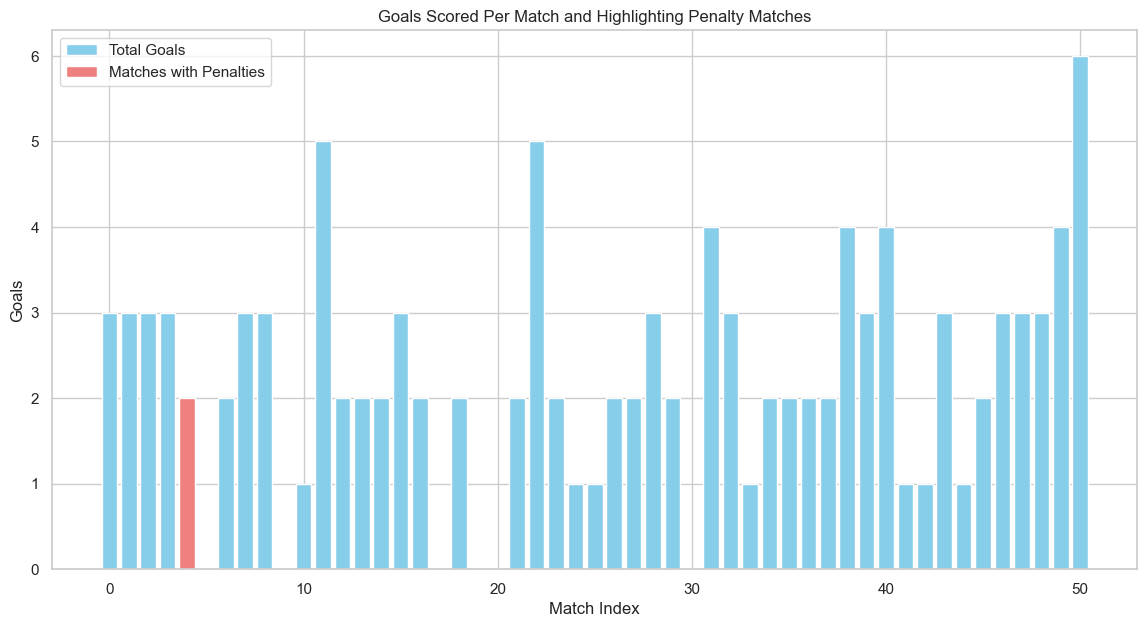

In [5]:
# Fill missing values for penalties
df['home_penalty'].fillna(0, inplace=True)
df['away_penalty'].fillna(0, inplace=True)

# Compute the total goals per match from home and away scores
df['goals'] = df['home_score'] + df['away_score']

# Determine matches where penalties were taken
penalty_mask = (df['home_penalty'] > 0) | (df['away_penalty'] > 0)

# Plotting the data
fig, ax = plt.subplots(figsize=(14, 7))

# Goals per match
ax.bar(df.index, df['goals'], color='skyblue', label='Total Goals')

# Highlighting matches with penalties
ax.bar(df.index[penalty_mask], df['goals'][penalty_mask], color='lightcoral', label='Matches with Penalties')

# Labeling the axes and setting the title
ax.set_xlabel('Match Index')
ax.set_ylabel('Goals')
ax.set_title('Goals Scored Per Match and Highlighting Penalty Matches')

# Adding a legend
ax.legend()

# Display the plot
plt.show()